In [58]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14, "axes.labelpad": 10})
import seaborn as sns
from scipy.stats import variation

In [59]:
df = pd.read_csv("cleaned_data.csv", dtype={"gender": str})

In [60]:
non_park_df= df[(df.subject == "C01") & (df.session == "u00003s00002_hw000011.svc")].reset_index(drop=True)
park_df = df[(df.subject == "T001") & (df.session == "u00005s00001_hw00001.svc")].reset_index(drop=True)

In [61]:
def plot_spiral_session(df):
    subject = df.subject.unique()[0]
    session = df.session.unique()[0]
    fig, ax1 = plt.subplots(figsize=(7, 6))

    ax1.scatter(df["x_coordinate"], df["y_coordinate"], s=2)
    ax1.set_xlabel("X Coordinate", labelpad=10)
    ax1.set_ylabel("Y Coordinate", labelpad=10)


    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

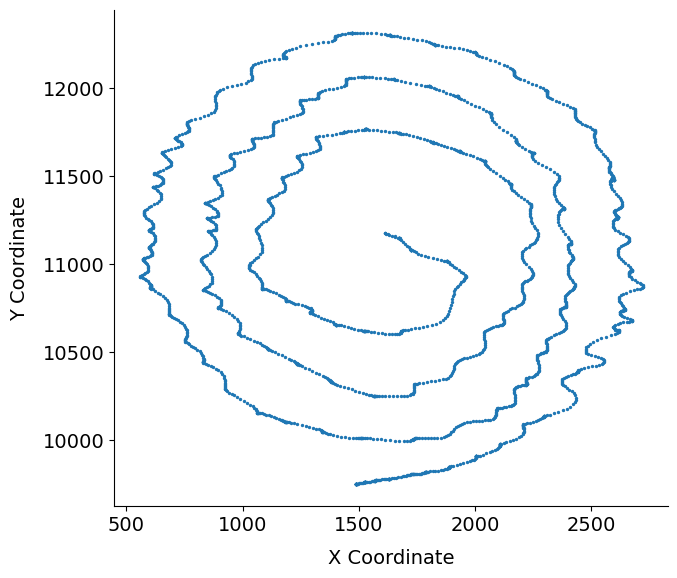

In [62]:
plot_spiral_session(park_df)

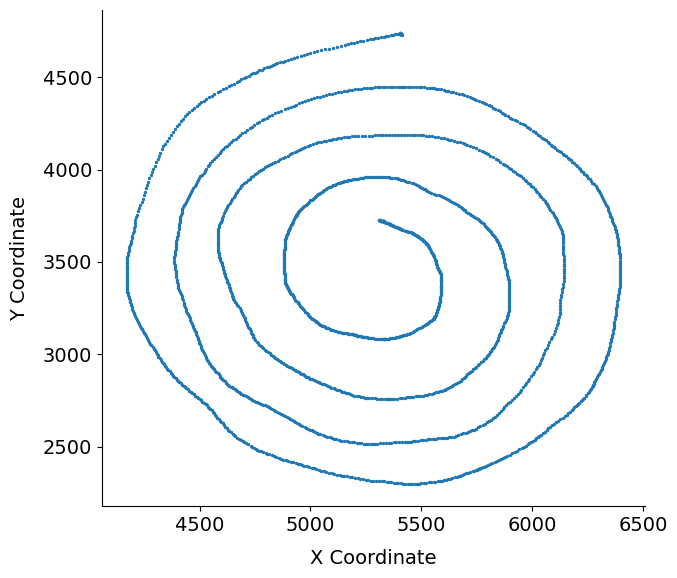

In [63]:
plot_spiral_session(non_park_df)

In [64]:
def analyze_tremor_frequency(df):
    df = df.copy()

    df["dx"] = df["x_coordinate"].diff()
    df["dy"] = df["y_coordinate"].diff()
    df["distance"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)

    df["dt"] = pd.to_datetime(df["date"]).diff().dt.total_seconds()

    df["speed"] = df["distance"] / df["dt"]

    speed_data = df["speed"].dropna().values

    N = len(speed_data)

    T = df["dt"].mean()

    yf = fft(speed_data)
    xf = fftfreq(N, T)[: N // 2]

    positive_freq = xf[1 : N // 2]
    magnitudes = 2.0 / N * np.abs(yf[1 : N // 2])
    
    min_freq = 1
    max_freq = 10
    mask = (positive_freq >= min_freq) & (positive_freq <= max_freq)
    dominant_freq = positive_freq[mask][np.argmax(magnitudes[mask])]

    fig,ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(positive_freq, magnitudes, color="blue", label="Frequency Spectrum")
    ax1.axvline(x=dominant_freq, color="red", linestyle="--", label=f"Dominant Frequency: {dominant_freq:.2f} Hz")
    ax1.set_xlabel("Frequency (Hz)", labelpad=10)
    ax1.set_ylabel("Magnitude", labelpad=10)
    ax1.legend(frameon=False)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    

    plt.tight_layout()
    plt.show()

    return dominant_freq

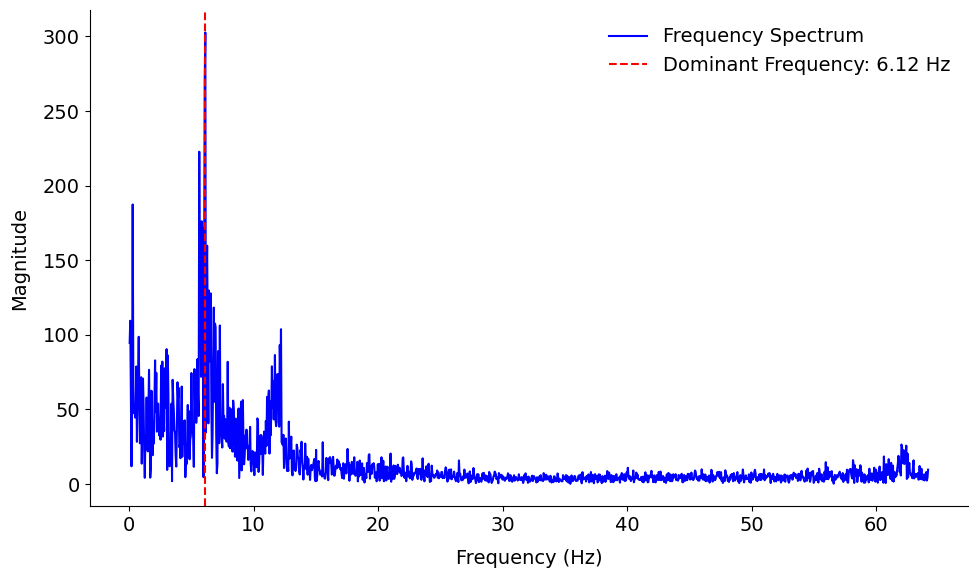

6.124829865837059

In [65]:
analyze_tremor_frequency(park_df)

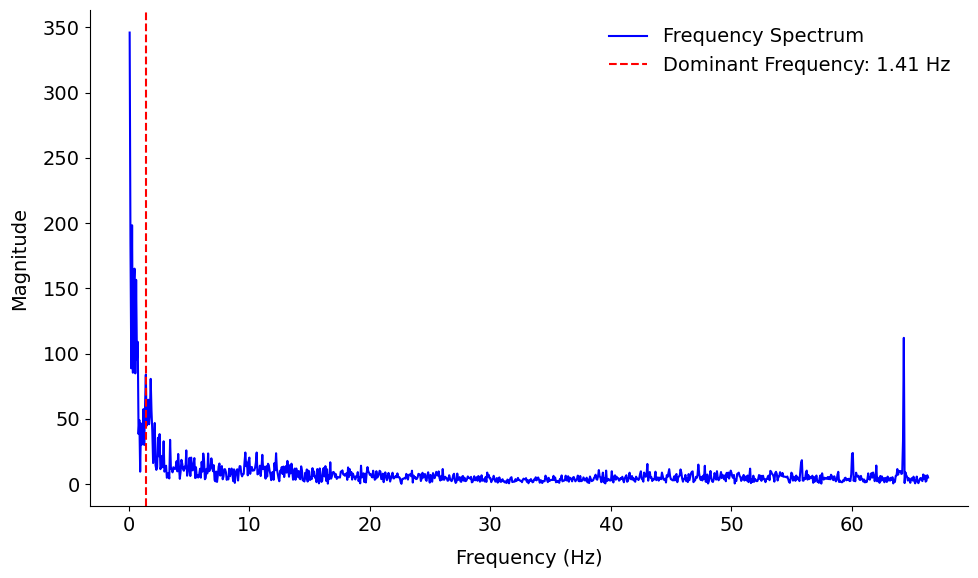

1.4096798013022749

In [66]:
analyze_tremor_frequency(non_park_df)

In [67]:
def calculate_metrics(df):
    df = df.copy()
    df["dx"] = df["x_coordinate"].diff()
    df["dy"] = df["y_coordinate"].diff()
    df["distance"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)
    df["dt"] = pd.to_datetime(df["date"]).diff().dt.total_seconds()
    df["speed"] = df["distance"] / df["dt"]

    speed_data = df["speed"].dropna().values
    N = len(speed_data)
    T = df["dt"].mean()
    yf = fft(speed_data)
    xf = fftfreq(N, T)[: N // 2]

    positive_freq = xf[1 : N // 2]
    magnitudes = 2.0 / N * np.abs(yf[1 : N // 2])
    mask = (positive_freq >= 1) & (positive_freq <= 10)
    dominant_freq = positive_freq[mask][np.argmax(magnitudes[mask])]

    speed_cv = variation(df["speed"].dropna())

    return {
        "dominant_frequency": dominant_freq,
        "speed_variability": speed_cv,
    }

In [68]:
metrics_list = []
subjects = df.subject.unique()

for subject in subjects:
    subject_df = df[df.subject == subject]
    for session in subject_df.session.unique():
        session_df = subject_df[
            (subject_df.session == session) & (subject_df.subject == subject)
        ]
        metrics = calculate_metrics(session_df)
        metrics['subject'] = subject
        metrics['session'] = session
        metrics['control'] = session_df.control.unique()[0]
        metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)

In [69]:
metrics_df["control_numeric"] = (metrics_df["control"] == "N").astype(int)
metrics_df

,dominant_frequency,speed_variability,subject,session,control,control_numeric
0,1.099399,0.328152,C01,u00003s00002_hw000012.svc,Y,0
1,1.409680,0.355251,C01,u00003s00002_hw000011.svc,Y,0
2,2.187829,0.307090,C02,u00004s00001_hw000011.svc,Y,0
3,1.328357,0.384199,C02,u00004s00001_hw000012.svc,Y,0
4,1.125828,0.283591,C03,u00005s00001_hw000011.svc,Y,0
5,1.176401,0.371980,C03,u00005s00001_hw000012.svc,Y,0
6,1.262523,0.456325,C04,u00006s00001_hw000012.svc,Y,0
7,1.775761,0.461092,C04,u00006s00001_hw000011.svc,Y,0
8,3.246026,0.438721,C05,u00007s00001_hw000012.svc,Y,0
9,1.043612,0.524839,C05,u00007s00001_hw000011.svc,Y,0


In [70]:
numeric_columns = metrics_df.select_dtypes(include=[np.number]).columns

control_group_means = metrics_df.groupby("control")[numeric_columns].mean()

print("Mean values for each metric by control group:")
control_group_means

Mean values for each metric by control group:


,dominant_frequency,speed_variability,control_numeric
control,,,
N,7.356441,1.174891,1.0
Y,1.625361,0.457326,0.0


In [71]:
metrics_df = metrics_df.drop(columns=["control"])
correlation_matrix = metrics_df[numeric_columns].corr("pearson")
correlation_matrix

,dominant_frequency,speed_variability,control_numeric
dominant_frequency,1.000000,0.711456,0.944650
speed_variability,0.711456,1.000000,0.689116
control_numeric,0.944650,0.689116,1.000000


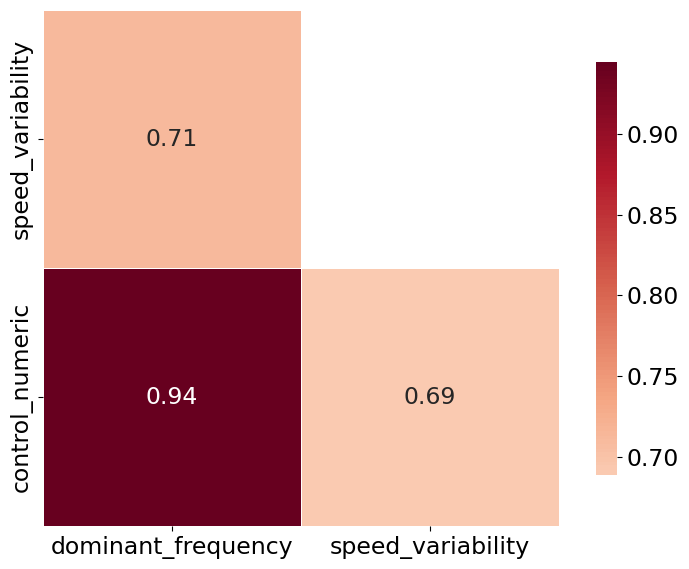

In [72]:
correlation_matrix_simplified = correlation_matrix.iloc[1:, :-1]

mask = np.zeros_like(correlation_matrix_simplified, dtype=bool)
mask[0, 1] = True

plt.rcParams.update({"font.size": 17, "axes.labelpad": 10})
plt.figure(figsize=(8, 6))

sns.heatmap(
    correlation_matrix_simplified,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0.6,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8},
    mask=mask,
)

plt.tight_layout()
plt.show()

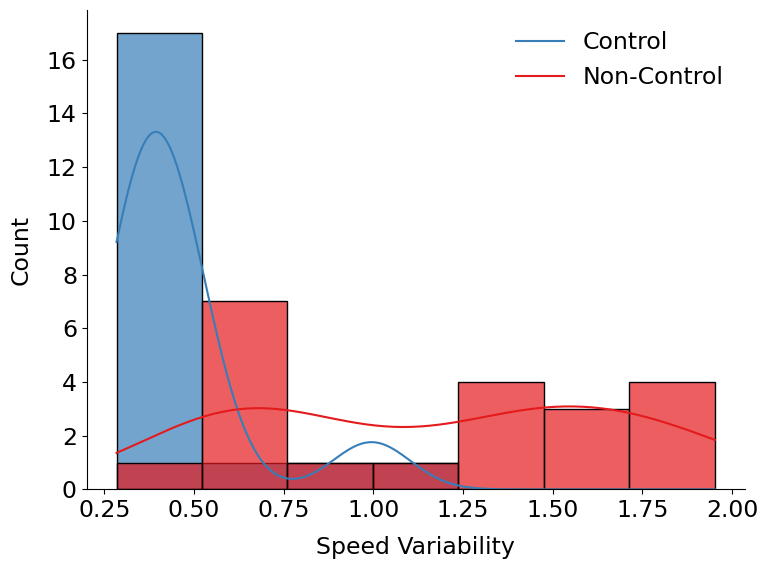

In [73]:
plot_df = metrics_df.copy()

fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [1, 0] 
legend_labels = {0: 'Non-Control', 1: 'Control'}
sns.histplot(plot_df, x="speed_variability", hue="control_numeric", kde=True, palette="Set1", alpha=0.7,  hue_order=hue_order)

plt.xlabel("Speed Variability", labelpad=10)
plt.ylabel("Count", labelpad=10)

plt.legend(labels=[legend_labels[i] for i in hue_order], frameon=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

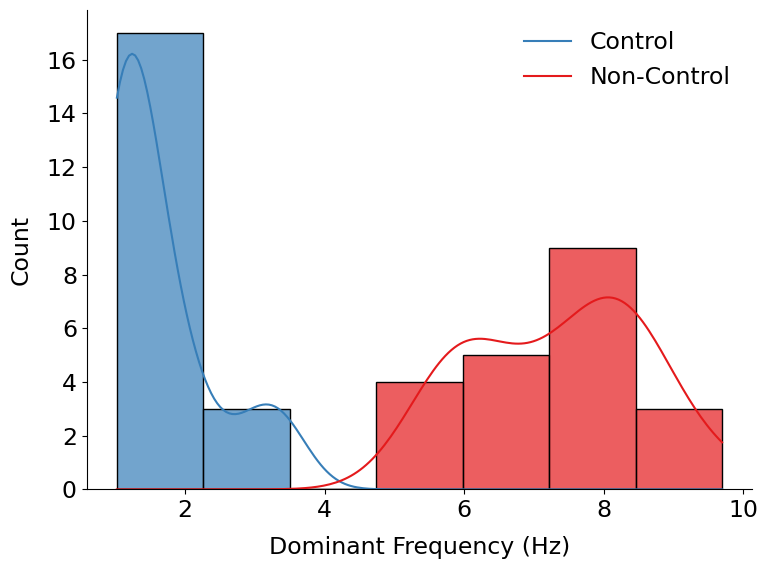

In [74]:
fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [1, 0] 
legend_labels = {0: 'Non-Control', 1: 'Control'}

patterns = ["/", "\\"]
line_styles = ["-", "--"]

sns.histplot(
            plot_df, 
            x="dominant_frequency", 
            hue="control_numeric", 
            kde=True, 
            palette="Set1", 
            alpha=0.7, 
            hue_order=hue_order)

plt.xlabel("Dominant Frequency (Hz)", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.legend(labels=[legend_labels[i] for i in hue_order], frameon=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

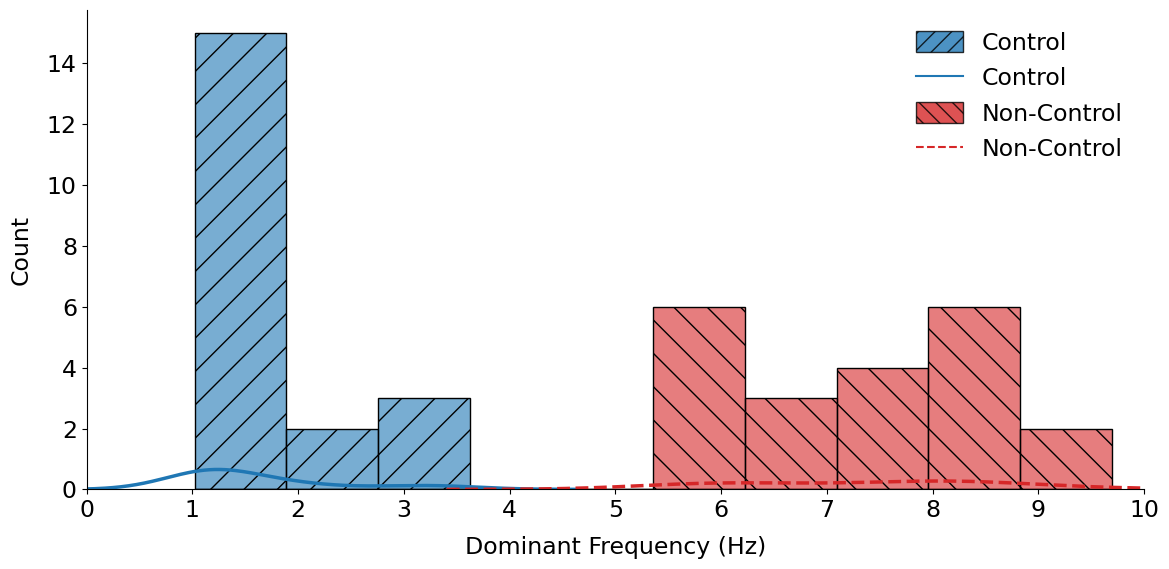

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plot_df = metrics_df.copy()
fig, ax = plt.subplots(figsize=(12, 6))

hue_order = [0, 1]
legend_labels = {0: "Non-Control", 1: "Control"}
patterns = ["/", "\\"]
colors = ["#1f77b4", "#d62728"]
line_styles = ["-", "--"]

all_data = plot_df["dominant_frequency"]
bins = np.linspace(all_data.min(), all_data.max(), 11)

for i, group in enumerate(hue_order):
    group_data = plot_df[plot_df["control_numeric"] == group]
    sns.histplot(
        data=group_data,
        x="dominant_frequency",
        bins=bins,
        kde=False,
        color=colors[i],
        edgecolor="black",
        hatch=patterns[i],
        alpha=0.6,
        label=legend_labels[group],
        ax=ax,
    )
    sns.kdeplot(
        data=group_data,
        x="dominant_frequency",
        color=colors[i],
        linestyle=line_styles[i],
        linewidth=2.5,
        ax=ax,
    )

plt.xlabel("Dominant Frequency (Hz)", labelpad=10)
plt.ylabel("Count", labelpad=10)

legend_elements = [
    Patch(
        facecolor=colors[0],
        edgecolor="black",
        hatch=patterns[0] * 2,
        label="Control",
        alpha=0.8,
    ),
    Line2D([0], [0], color=colors[0], linestyle=line_styles[0], label="Control"),
    Patch(
        facecolor=colors[1],
        edgecolor="black",
        hatch=patterns[1] * 2,
        label="Non-Control",
        alpha=0.8,
    ),
    Line2D([0], [0], color=colors[1], linestyle=line_styles[1], label="Non-Control"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=False,
    handlelength=2,
    handleheight=1,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

x_max = np.ceil(all_data.max())
ax.set_xlim(0, x_max)
ax.set_xticks(np.linspace(0, x_max, 11))

plt.tight_layout()
plt.show()

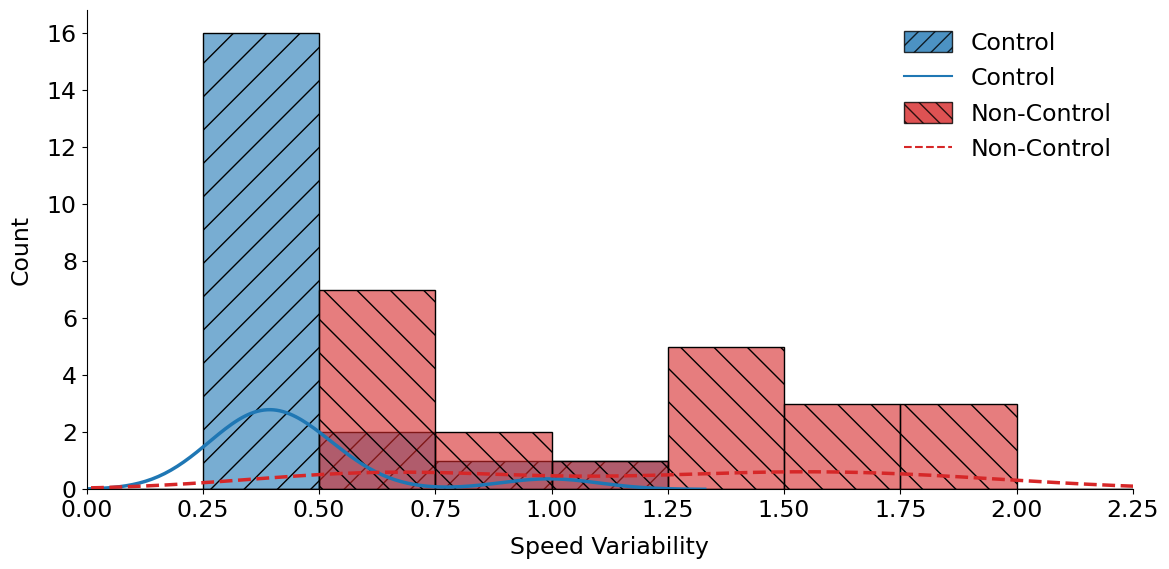

In [76]:
plot_df = metrics_df.copy()

fig, ax = plt.subplots(figsize=(12, 6))

hue_order = [0, 1]
legend_labels = {0: "Non-Control", 1: "Control"}
patterns = ["/", "\\"]
colors = ["#1f77b4", "#d62728"] 
line_styles = ["-", "--"]

bins = np.linspace(0, 2.5, 11) 

for i, group in enumerate(hue_order):
    group_data = plot_df[plot_df["control_numeric"] == group]

    sns.histplot(
        data=group_data,
        x="speed_variability",
        bins=bins,
        kde=False,
        color=colors[i],
        edgecolor="black",
        hatch=patterns[i],
        alpha=0.6,
        label=legend_labels[group],
        ax=ax,
    )

    sns.kdeplot(
        data=group_data,
        x="speed_variability",
        color=colors[i],
        linestyle=line_styles[i],
        linewidth=2.5,
        ax=ax,
    )

plt.xlabel("Speed Variability", labelpad=10)
plt.ylabel("Count", labelpad=10)


legend_elements = [
    Patch(
        facecolor=colors[0],
        edgecolor="black",
        hatch=patterns[0] * 2,
        label="Control",
        alpha=0.8,
    ),
    Line2D([0], [0], color=colors[0], linestyle=line_styles[0], label="Control"),
    Patch(
        facecolor=colors[1],
        edgecolor="black",
        hatch=patterns[1] * 2,
        label="Non-Control",
        alpha=0.8,
    ),
    Line2D([0], [0], color=colors[1], linestyle=line_styles[1], label="Non-Control"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=False,
    handlelength=2,
    handleheight=1,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim(0, 2.25)

ax.set_xticks(np.arange(0, 2.5, 0.25))

plt.tight_layout()
plt.show()